# 인물 모드 문제점 찾기

* 주요 라이브러리 버전을 확인

In [3]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


## Step 1. 인물모드 직접 해 보기

* 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
* 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
* 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

In [4]:
#라이브러리 추가
import os
import urllib               # 웹에서 데이터를 다운로드할 때 사용
import cv2                  # OpenCV 라이브러리로 이미지를 처리하기 위해 필요
import numpy as np
from pixellib.semantic import semantic_segmentation   #시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt

#-------------------------------------------
#PixelLib에서 제공해 주는 모델을 다운로드
#-------------------------------------------
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

#-------------------------------------------
# 다운로드를 시작합니다
#-------------------------------------------
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

#다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()  #클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file)  # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출


## (1) 사진 준비

(5616, 3744, 3)


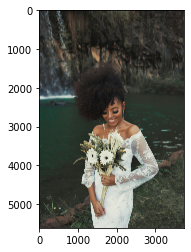

In [6]:
#-------------------------------------------
#이미지 읽기
#-------------------------------------------
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image1.jpg' 
img_orig = cv2.imread(img_path) 
print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## (2) 세그멘테이션으로 사람 분리하기

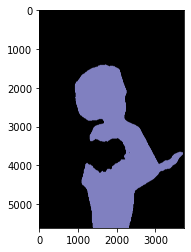

background
person
[192 128 128]
[0 0 0]
(5616, 3744)


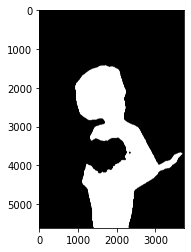

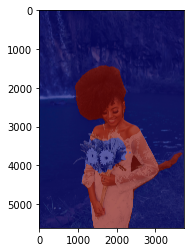

In [7]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)  #입력된 이미지를 분할, 분할 출력의 배열을 가져옴

#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

len(LABEL_NAMES)

#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

# segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력
segvalues 

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    
#-------------------------------------------    
#컬러맵 만들기 
#-------------------------------------------
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력    

#-------------------------------------------------------------------------
#컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)
#-------------------------------------------------------------------------
colormap[15]  #사람
print(colormap[15])
colormap[0]   #배경
print(colormap[0])

#---------------------------------------------------------------------------------------------------
#우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 함
# 색상순서 변경 - colormap의 배열은 RGB 순이며 
# output의 배열은 BGR 순서로 채널 배치가 되어 있어서, colormap의 순서를 output의 순서에 맞게 변경필요(뒤집어서 읽기)
# ---------------------------------------------------------------------------------------------------
# colormap , RGB 순서 : array([192: R, 128 : G , 128 : B]) 
# output,   BGR 순서 -> [128 : B, 128 : G, 192: R]
seg_color = (128,128,192) 

#---------------------------------------
#seg_color로만 이루어진 마스크 생성
#---------------------------------------
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

#------------------------
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
#------------------------
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.4, color_mask, 0.6, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## (3) 배경 흐리게 하기

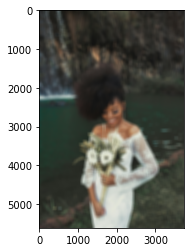

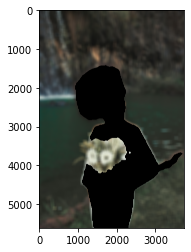

In [8]:
img_orig_blur = cv2.blur(img_orig, (100,100))  #(13,13)은 blurring kernel size

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))  #입력 이미지의 색상 채널을 변경
plt.show()


#-----------------------------
#흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
#-----------------------------
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)  #이미지가 반전

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)  #배경만 있는 영상
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()



* img_bg_blur 결과 (배경만 있는 영상)

- bitwise_not 함수 : 이미지가 반전(배경:0, 사람:255 -> 배경:255, 사람:0)
- bitwise_and 연산을 수행 : 세그멘테이션 결과를 이용해서 이미지 연산후 -> 배경만 있는 영상을 얻음

## (4) 흐린 배경과 원본 영상 합성

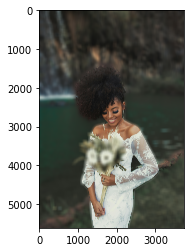

In [9]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)  #사람:255, 배경:0

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

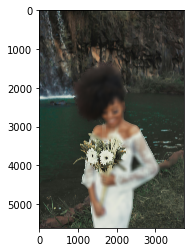

In [10]:
img_concat = np.where(img_mask_color==0, img_orig, img_orig_blur) #원본:img_orig, 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

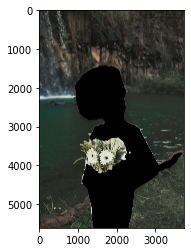

In [11]:
img_concat = np.where(img_mask_color==0, img_orig, img_bg_blur) #원본:img_orig, 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

4.5.3
0.7.1
(2900, 1933, 3)


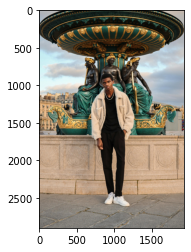

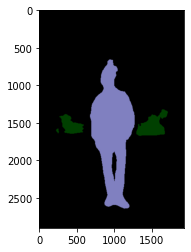

background
person
pottedplant
[192 128 128]
[0 0 0]
(2900, 1933)


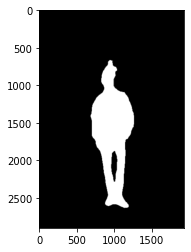

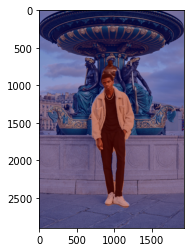

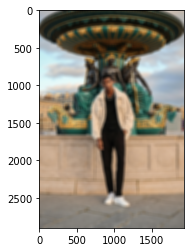

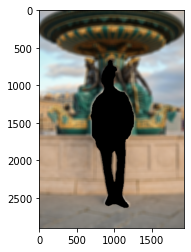

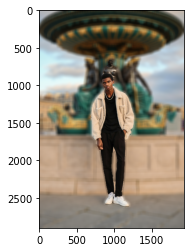

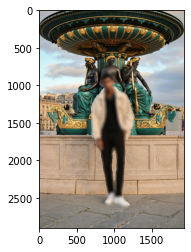

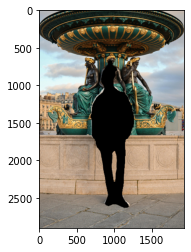

In [12]:
from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

#라이브러리 추가
import os
import urllib               # 웹에서 데이터를 다운로드할 때 사용
import cv2                  # OpenCV 라이브러리로 이미지를 처리하기 위해 필요
import numpy as np
from pixellib.semantic import semantic_segmentation   #시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt

#-------------------------------------------
#PixelLib에서 제공해 주는 모델을 다운로드
#-------------------------------------------
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

#-------------------------------------------
# 다운로드를 시작합니다
#-------------------------------------------
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

#다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()  #클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file)  # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

#(1) 사진 준비
#-------------------------------------------
#이미지 읽기
#-------------------------------------------
#img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image2.jpg'  
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image3.jpg'  
img_orig = cv2.imread(img_path) 
print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# (2) 세그멘테이션으로 사람 분리하기
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)  #입력된 이미지를 분할, 분할 출력의 배열을 가져옴

#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

len(LABEL_NAMES)

#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

# segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력
segvalues 

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    
#-------------------------------------------    
#컬러맵 만들기 
#-------------------------------------------
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력    

#-------------------------------------------------------------------------
#컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)
#-------------------------------------------------------------------------
colormap[15]  #사람
print(colormap[15])
colormap[0]   #배경
print(colormap[0])

#---------------------------------------------------------------------------------------------------
#우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 함
# 색상순서 변경 - colormap의 배열은 RGB 순이며 
# output의 배열은 BGR 순서로 채널 배치가 되어 있어서, colormap의 순서를 output의 순서에 맞게 변경필요(뒤집어서 읽기)
# ---------------------------------------------------------------------------------------------------
# colormap , RGB 순서 : array([192: R, 128 : G , 128 : B]) 
# output,   BGR 순서 -> [128 : B, 128 : G, 192: R]
seg_color = (128,128,192) 

#---------------------------------------
#seg_color로만 이루어진 마스크 생성
#---------------------------------------
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

#------------------------
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
#------------------------
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_orig_blur = cv2.blur(img_orig, (50,50))  #(13,13)은 blurring kernel size

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))  #입력 이미지의 색상 채널을 변경
plt.show()


# (3) 배경 흐리게 하기

#-----------------------------
#흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
#-----------------------------
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)  #이미지가 반전

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)  #배경만 있는 영상
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#(4) 흐린 배경과 원본 영상 합성
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)  #사람:255, 배경:0

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==0, img_orig, img_orig_blur) #원본:img_orig, 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==0, img_orig, img_bg_blur) #원본:img_orig, 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

4.5.3
0.7.1
(6000, 4000, 3)


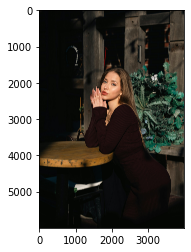

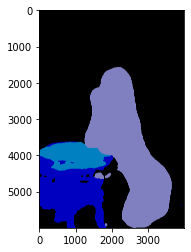

background
chair
diningtable
person
[192 128 128]
[0 0 0]
(6000, 4000)


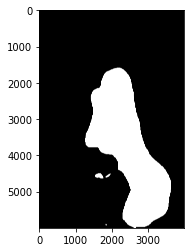

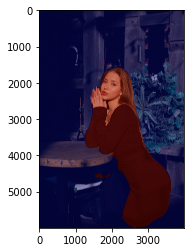

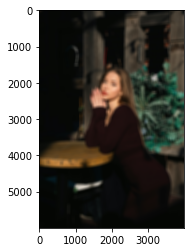

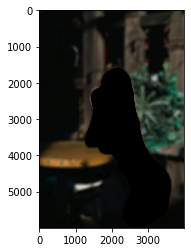

In [ ]:
from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

#라이브러리 추가
import os
import urllib               # 웹에서 데이터를 다운로드할 때 사용
import cv2                  # OpenCV 라이브러리로 이미지를 처리하기 위해 필요
import numpy as np
from pixellib.semantic import semantic_segmentation   #시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt

#-------------------------------------------
#PixelLib에서 제공해 주는 모델을 다운로드
#-------------------------------------------
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

#-------------------------------------------
# 다운로드를 시작합니다
#-------------------------------------------
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

#다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()  #클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file)  # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

#(1) 사진 준비
#-------------------------------------------
#이미지 읽기
#-------------------------------------------
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image2.jpg'    
img_orig = cv2.imread(img_path) 
print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# (2) 세그멘테이션으로 사람 분리하기
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)  #입력된 이미지를 분할, 분할 출력의 배열을 가져옴

#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

len(LABEL_NAMES)

#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

# segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력
segvalues 

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    
#-------------------------------------------    
#컬러맵 만들기 
#-------------------------------------------
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력    

#-------------------------------------------------------------------------
#컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)
#-------------------------------------------------------------------------
colormap[15]  #사람
print(colormap[15])
colormap[0]   #배경
print(colormap[0])

#---------------------------------------------------------------------------------------------------
#우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 함
# 색상순서 변경 - colormap의 배열은 RGB 순이며 
# output의 배열은 BGR 순서로 채널 배치가 되어 있어서, colormap의 순서를 output의 순서에 맞게 변경필요(뒤집어서 읽기)
# ---------------------------------------------------------------------------------------------------
# colormap , RGB 순서 : array([192: R, 128 : G , 128 : B]) 
# output,   BGR 순서 -> [128 : B, 128 : G, 192: R]
seg_color = (128,128,192) 

#---------------------------------------
#seg_color로만 이루어진 마스크 생성
#---------------------------------------
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

#------------------------
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
#------------------------
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_orig_blur = cv2.blur(img_orig, (100,100))  #(13,13)은 blurring kernel size

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))  #입력 이미지의 색상 채널을 변경
plt.show()


# (3) 배경 흐리게 하기

#-----------------------------
#흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
#-----------------------------
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)  #이미지가 반전

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)  #배경만 있는 영상
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#(4) 흐린 배경과 원본 영상 합성
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)  #사람:255, 배경:0

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==0, img_orig, img_orig_blur) #원본:img_orig, 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==0, img_orig, img_bg_blur) #원본:img_orig, 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

4.5.3
0.7.1
(2340, 1080, 3)


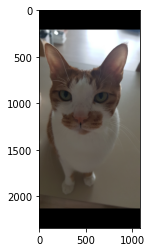

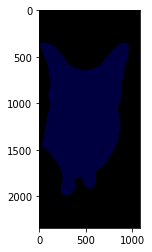

background
cat
[64  0  0]
[0 0 0]
(2340, 1080)


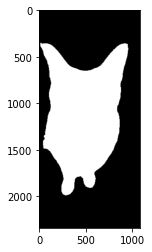

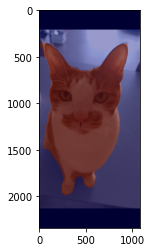

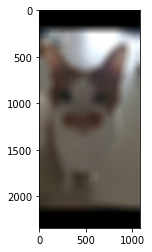

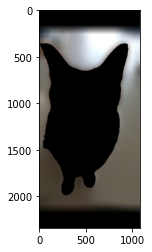

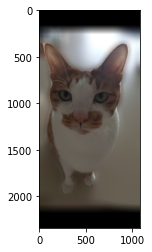

In [13]:
from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

#라이브러리 추가
import os
import urllib               # 웹에서 데이터를 다운로드할 때 사용
import cv2                  # OpenCV 라이브러리로 이미지를 처리하기 위해 필요
import numpy as np
from pixellib.semantic import semantic_segmentation   #시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt

#-------------------------------------------
#PixelLib에서 제공해 주는 모델을 다운로드
#-------------------------------------------
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

#-------------------------------------------
# 다운로드를 시작합니다
#-------------------------------------------
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

#다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()  #클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file)  # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

#(1) 사진 준비
#-------------------------------------------
#이미지 읽기
#-------------------------------------------
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image4.jpg'    
img_orig = cv2.imread(img_path) 
print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# (2) 세그멘테이션으로 사람 분리하기
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)  #입력된 이미지를 분할, 분할 출력의 배열을 가져옴

#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

len(LABEL_NAMES)

#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

# segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력
segvalues 

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    
#-------------------------------------------    
#컬러맵 만들기 
#-------------------------------------------
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력    

#-------------------------------------------------------------------------
#컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)
#-------------------------------------------------------------------------
colormap[8]  #고양이
print(colormap[8])
colormap[0]   #배경
print(colormap[0])

#---------------------------------------------------------------------------------------------------
#우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 함
# 색상순서 변경 - colormap의 배열은 RGB 순이며 
# output의 배열은 BGR 순서로 채널 배치가 되어 있어서, colormap의 순서를 output의 순서에 맞게 변경필요(뒤집어서 읽기)
# ---------------------------------------------------------------------------------------------------
# colormap , RGB 순서 : array([64  0  0]) 
# output,   BGR 순서 -> [0,0,64]
seg_color = (0,0,64) 

#---------------------------------------
#seg_color로만 이루어진 마스크 생성
#---------------------------------------
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

#------------------------
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
#------------------------
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_orig_blur = cv2.blur(img_orig, (100,100))  #(13,13)은 blurring kernel size

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))  #입력 이미지의 색상 채널을 변경
plt.show()


# (3) 배경 흐리게 하기

#-----------------------------
#흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
#-----------------------------
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)  #이미지가 반전

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)  #배경만 있는 영상
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#(4) 흐린 배경과 원본 영상 합성
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)  #사람:255, 배경:0

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


#### 배경 바꿔보기 (크로마키 배경 합성)

4.5.3
0.7.1
(500, 892, 3)


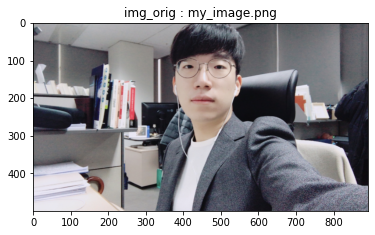

(168, 300, 3)


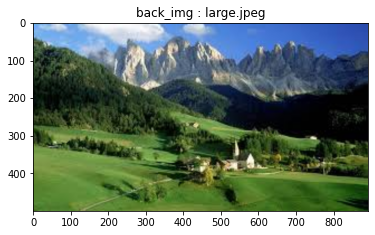

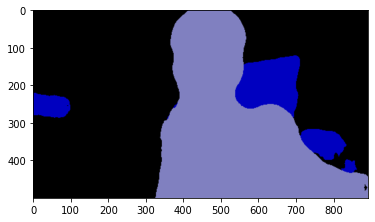

background
chair
person
[192 128 128]
[0 0 0]
(500, 892)


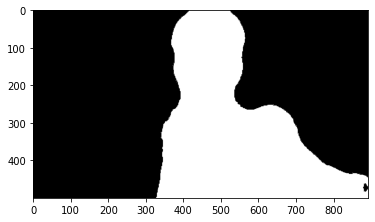

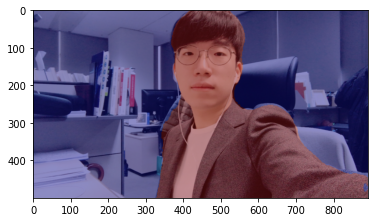

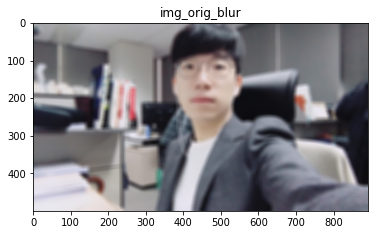

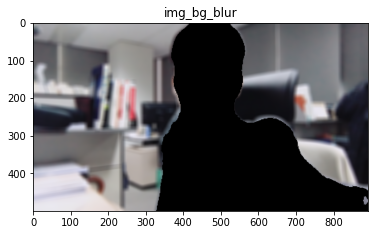

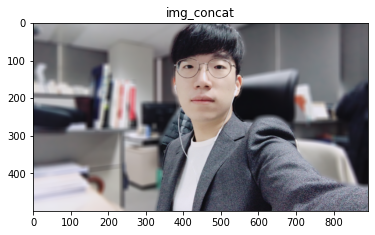

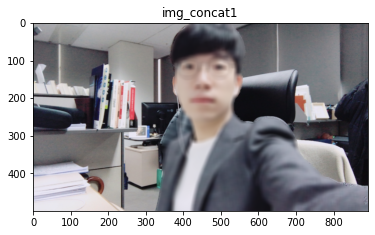

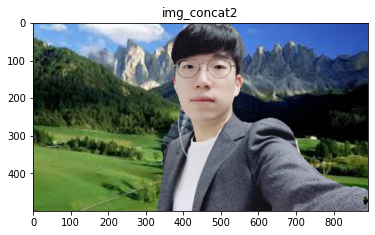

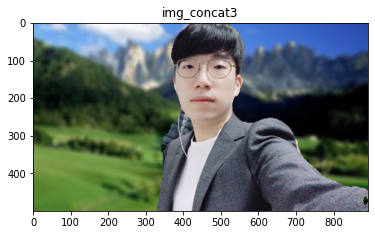

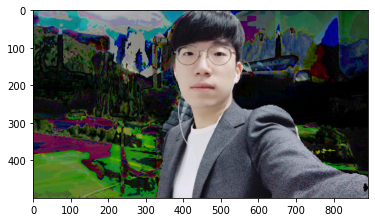

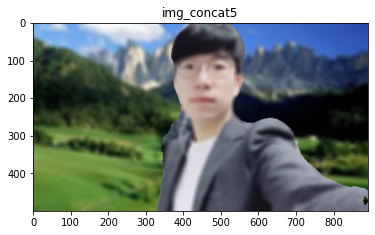

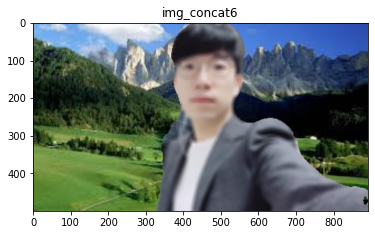

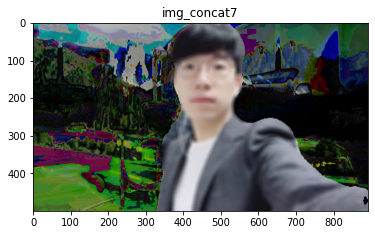

Chroma key result saved at: /aiffel/aiffel/human_segmentation/images/output7.png


In [64]:
from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

#라이브러리 추가
import os
import urllib               # 웹에서 데이터를 다운로드할 때 사용
import cv2                  # OpenCV 라이브러리로 이미지를 처리하기 위해 필요
import numpy as np
from pixellib.semantic import semantic_segmentation   #시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt
from pixellib.tune_bg import alter_bg

#-------------------------------------------
#PixelLib에서 제공해 주는 모델을 다운로드
#-------------------------------------------
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

#-------------------------------------------
# 다운로드를 시작합니다
#-------------------------------------------
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

#다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()  #클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file)  # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

#(1) 사진 준비
#-------------------------------------------
#이미지 읽기
#-------------------------------------------
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'
img_orig = cv2.imread(img_path) 
print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title("img_orig : my_image.png")
plt.show()

#배경화면 load(크로미카합성 추가된 부분)
background_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/large7.jpg'  #large5,6,7,8.jpg
back_img = cv2.imread(background_path) 
print(back_img.shape)

# 셀카 크기에 맞게 배경 크기 조정
back_img = cv2.resize(back_img, (img_orig.shape[1], img_orig.shape[0]))

plt.imshow(cv2.cvtColor(back_img, cv2.COLOR_BGR2RGB))
plt.title("back_img : large.jpeg")
plt.show()

# (2) 세그멘테이션으로 사람 분리하기
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)  #입력된 이미지를 분할, 분할 출력의 배열을 가져옴

#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

len(LABEL_NAMES)

#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

# segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력
segvalues 

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    
#-------------------------------------------    
#컬러맵 만들기 
#-------------------------------------------
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력    

#-------------------------------------------------------------------------
#컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)
#-------------------------------------------------------------------------
colormap[15]  #사람
print(colormap[15])
colormap[0]   #배경
print(colormap[0])

#---------------------------------------------------------------------------------------------------
#우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 함
# 색상순서 변경 - colormap의 배열은 RGB 순이며 
# output의 배열은 BGR 순서로 채널 배치가 되어 있어서, colormap의 순서를 output의 순서에 맞게 변경필요(뒤집어서 읽기)
# ---------------------------------------------------------------------------------------------------
# colormap , RGB 순서 : array([192: R, 128 : G , 128 : B]) 
# output,   BGR 순서 -> [128 : B, 128 : G, 192: R]
seg_color = (128,128,192) 

#---------------------------------------
#seg_color로만 이루어진 마스크 생성
#---------------------------------------
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

#------------------------
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
#------------------------
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

img_mask_inv = cv2.bitwise_not(img_mask)    #크로미카합성 추가된 부분

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_orig_blur = cv2.blur(img_orig, (13,13))  #(13,13)은 blurring kernel size

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))  #입력 이미지의 색상 채널을 변경
plt.title("img_orig_blur")
plt.show()


# (3) 배경 흐리게 하기
#-----------------------------
#흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
#-----------------------------
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)  #이미지가 반전

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)  #배경만 있는 영상
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.title("img_bg_blur")
plt.show()


#(4) 흐린 배경과 원본 영상 합성
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)  #사람:255, 배경:0
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title("img_concat")
plt.show()


img_concat1 = np.where(img_mask_color==0, img_orig, img_orig_blur) #원본:img_orig, 
plt.imshow(cv2.cvtColor(img_concat1, cv2.COLOR_BGR2RGB))
plt.title("img_concat1")
plt.show()


#-----------------------------
# (5) 새 이미지에서 배경 추출
#-----------------------------
new_background = cv2.bitwise_and(back_img, back_img, img_mask_inv)  #새배경 영상
new_back_blur1 = cv2.bitwise_and(new_background, img_bg_blur)       #새배경+배경만 있는 영상의 효과를 준것
new_back_blur = cv2.blur(new_background, (13,13))  #(13,13)은 blurring kernel size

#새 배경과 원본 영상 합성
img_concat2= np.where(img_mask_color==255, img_orig, new_background)  #사람:255, 배경:0
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.title("img_concat2")
plt.show()

#새 배경의 흐린 배경과 원본 영상 합성
img_concat3 = np.where(img_mask_color==255, img_orig, new_back_blur)  #사람:255(원본), 배경:0(블러)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.title("img_concat3")
plt.show()

#새배경+배경만 있는 영상의 효과를 준것, 원본 영상 합침
img_concat4 = np.where(img_mask_color==255, img_orig, new_back_blur1)  #사람:255, 배경:0
plt.imshow(cv2.cvtColor(img_concat4, cv2.COLOR_BGR2RGB))
plt.show()

#사람 부분을 블러로, 배경 부분을 원본으로 처리
img_concat5 = np.where(img_mask_color==0, new_back_blur, img_orig_blur)   #사람:255(블러), 배경:0(원본)
plt.imshow(cv2.cvtColor(img_concat5, cv2.COLOR_BGR2RGB))
plt.title("img_concat5")
plt.show()

#사람 부분을 블러로, 배경 부분을 원본으로 처리
img_concat6 = np.where(img_mask_color==0, new_background, img_orig_blur)   #사람:255(블러), 배경:0(원본)
plt.imshow(cv2.cvtColor(img_concat6, cv2.COLOR_BGR2RGB))
plt.title("img_concat6")
plt.show()

#사람 부분을 블러로, 배경 부분을 원본으로 처리
img_concat7 = np.where(img_mask_color==0, new_back_blur1, img_orig_blur)   #사람:255(블러), 배경:0(원본)
plt.imshow(cv2.cvtColor(img_concat7, cv2.COLOR_BGR2RGB))
plt.title("img_concat7")
plt.show()

# 최종 결과 저장
output_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/output.png'
cv2.imwrite(output_path, img_concat)
output_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/output1.png'
cv2.imwrite(output_path, img_concat1)
output_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/output2.png'
cv2.imwrite(output_path, img_concat2)
output_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/output3.png'
cv2.imwrite(output_path, img_concat3)
output_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/output4.png'
cv2.imwrite(output_path, img_concat4)
output_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/output5.png'
cv2.imwrite(output_path, img_concat5)
output_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/output6.png'
cv2.imwrite(output_path, img_concat6)
output_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/output7.png'
cv2.imwrite(output_path, img_concat7)
print(f"Chroma key result saved at: {output_path}")

## Step 2. 사진에서 문제점 찾기

* 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.